## HLS Subsetting using Granule ID search


## Background
NASA's Land Processes Distributed Active Archive Center (LP DAAC) archives and distributes Harmonized Landsat Sentinel-2 (HLS) version 2.0 products in the LP DAAC Cumulus cloud archive as Cloud Optimized GeoTIFFs (COG)

The ```HLS_SuPER.py``` data prep script is a command line-executable Python script that allows users to submit inputs for their desired spatial (GeoJSON, Shapefile, bounding box) region of interest (ROI), time period of interest, and the specific desired product(s) and bands/layers within the HLS products. 

This command is, however, missing a function to filter the search outputs by granual IDs, which is limited by the capacity of CMR-STAC in retrieving the query based on the subsetting of granual ID.  

This tutorial aims to instruct on how to search the HLS data by granule ID for a specific domain. To construct these outputs, the input arguments provided by the user in command line are submitted to NASA's Common Metadata Repository API endpoint via the ```earthaccess``` Python library to find data. The current search function from ```earthaccess``` lacks of a feature to filter out the output by granule ID. 

Simply speaking, this work can contribute to current development of ```earthaccess``` package to enable the search feature by granule ID, which have useful implications in many research developments.



## Requirements
A NASA Earthdata Login account is required to download the data used in this tutorial. You can create an account at the link provided.


## Learning Objectives
How to work with HLS Landsat (HLSL30.002) and Sentinel-2 (HLSS30.002) data products
How to use CMR-STAC to search for HLS data
How to access and work with HLS data using ```dask``` and ```OpenDataCube```

## Data Used
Daily 30 meter (m) global HLS Sentinel-2 Multi-spectral Instrument Surface Reflectance - HLSS30.002
- The HLSS30 product provides 30 m Nadir normalized Bidirectional Reflectance Distribution Function (BRDF)-Adjusted Reflectance (NBAR) and is derived from Sentinel-2A and Sentinel-2B MSI data products.

Daily 30 meter (m) global HLS Landsat-8 OLI Surface Reflectance - HLSL30.002
- The HLSL30 product provides 30 m Nadir normalized Bidirectional Reflectance Distribution Function (BRDF)-Adjusted Reflectance (NBAR) and is derived from Landsat-8 OLI data products.
Science Dataset (SDS) layers:




## Tutorial Outline
<font color="blue">[1. Getting started](#1.-Getting-started)</font> 
- <font color="blue">[1.1. Python Environment and Packages](#1.1.-Python-Environment-and-Packages) </font> 
- <font color="blue">[1.2. EarthData Login](#1.2.-Earthdata-Login)</font> 
- <font color="blue">[1.3. Configure GDAL Options and rio environment](#1.3.-Configure-GDAL-Options-and-rio-environment)</font> 

<font color="blue">[2. CMR-STAC Search](#2.-CMR-STAC-Search)</font> 
- <font color="blue">[2.1 Why search by granule ID is a useful feature?](#2.1-Why-search-by-granule-ID-is-a-useful-feature?) </font>
- <font color="blue">[2.2 What are the challenges?](#2.2-What-are-the-challenges?) </font>
- <font color="blue">[2.3 What is the solution?](#2.3-What-is-the-solution?) </font>


-----------------------------------------------------------------------------------------------------------------------------------------

# 1. Getting started


## 1.1. Python Environment and Packages

A compatible python environment can be created by following the Python Environment setup instructions, activating that environment and adding the pystac-client and odc-stac packages:



In [ ]:
mamba create -n lpdaac_vitals -c conda-forge --yes python=3.10 \
gdal=3.7.2 hvplot geoviews rioxarray rasterio geopandas fiona=1.9.4 \
jupyter earthaccess jupyter_bokeh h5py h5netcdf spectral scikit-image \
seaborn jupyterlab dask ray-default ray-dashboard pystac-client odc-stac contextily

In [2]:
mamba activate lpdaac_vitals

Run 'mamba init' to be able to run mamba activate/deactivate
and start a new shell session. Or use conda to activate/deactivate.


Note: you may need to restart the kernel to use updated packages.


In [9]:
%matplotlib inline

import os
from datetime import datetime
import numpy as np
import pandas as pd
import geopandas as gp
from skimage import io
import matplotlib.pyplot as plt
from osgeo import gdal
import xarray as xr
import rioxarray as rxr
import hvplot.xarray
import hvplot.pandas
import earthaccess
import pystac_client
import dask.distributed
import odc.stac
import xarray as xr
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import contextily
%run -i ./tools/plotting.ipynb
%run -i ./tools/data_access.ipynb
%run -i ./tools/ultilities.ipynb

## 1.2. Earthdata Login

We will use the earthaccess package for authentication. <font color="blue">[earthaccess](https://github.com/nsidc/earthaccess#readme)</font> can either createa a new local .netrc file to store credentials or validate that one exists already in you user profile. If you do not have a .netrc file, you will be prompted for your credentials and one will be created.

In [5]:
earthaccess.login(persist=True)

Enter your Earthdata Login username:  trangthuyvo
Enter your Earthdata password:  ········


In [ ]:
# anomynous when publish or share with lpdaac

## 1.3. Configure GDAL Options and rio environment

In [6]:
# GDAL configurations used to successfully access LP DAAC Cloud Assets via vsicurl 
gdal.SetConfigOption('GDAL_HTTP_COOKIEFILE','~/cookies.txt')
gdal.SetConfigOption('GDAL_HTTP_COOKIEJAR', '~/cookies.txt')
gdal.SetConfigOption('GDAL_DISABLE_READDIR_ON_OPEN','EMPTY_DIR')
gdal.SetConfigOption('CPL_VSIL_CURL_ALLOWED_EXTENSIONS','TIF')
gdal.SetConfigOption('GDAL_HTTP_UNSAFESSL', 'YES')
gdal.SetConfigOption('GDAL_HTTP_MAX_RETRY', '10')
gdal.SetConfigOption('GDAL_HTTP_RETRY_DELAY', '0.5')
gdal.SetConfigOption('CPL_VSIL_CURL_USE_HEAD', 'FALSE')

# 2. CMR-STAC Search

To find the HLS data for a certain purpose, there are some analysis parameters to define:

The following cell set important parameters for the analysis:

* ```lat```: The central latitude to analyse.
* ```lon```: The central longitude to analyse.
* ```buffer```: The number of square degrees to load around the central latitude and longitude. For reasonable loading times, set this as 0.1 or lower.
* ```baseline_year```: The baseline year, to use as the baseline (or starting time) of urbanisation 
* ```analysis_year```: The analysis year to analyse the change in urbanisation

To demonstrate the issues of overlapping tiles over polar domain, let consider an AOI near the pole for the search. 

In [1]:
# Define the analysis parameter for the analysis 
lat = 72.6
lon = -94
buffer_lat = 0.001
buffer_lon = 0.001
baseline_year = 2021
analysis_year = 2021

In [2]:
# Combine central lat,lon with buffer to get area of interest
lat_range = (lat - buffer_lat, lat + buffer_lat)
lon_range = (lon - buffer_lon, lon + buffer_lon)

The next cell will display the selected area on an interactive map. Feel free to zoom in and out to get a better understanding of the area you'll be analysing. Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.


In [10]:
display_map(lon_range, lat_range,centroid=[lat,lon])

To find HLS data, we will use the pystac_client python library to search NASA's Common Metadata Repository SpatioTemporal Asset Catalog (CMR-STAC) for HLS data.

Add the collection, datetime range, results limit, a bounding box and store these as search parameters. After defining these, conduct a stac search using the LPCLOUD STAC endpoint and return our query as a list of items.


## 2.1. Why search by granule ID is a useful feature?

In [10]:
%timeit
date_begin = '03-11'
date_end = '03-11'
item_list = search_cmr_stac(baseline_year,analysis_year,lat_range,lon_range,date_begin,date_end)

2021
Found 2 granules at point [-94.001, 72.59899999999999, -93.999, 72.601] from 2021-03-11 to 2021-03-11


As a result, we have in total 2 S30 tiles retrieved over **1 point** for March 11, 2021. 


Let us dig into the detail why there are too many tiles over a point?

In [11]:
df_geo = pystac_to_json(item_list)
df_geo.crs = "epsg:4326"
len(np.unique(df_geo['granule_id']))

2

There are in total **2** unique granule ID over this region. To show how these granules geographically distributed, let look at the map

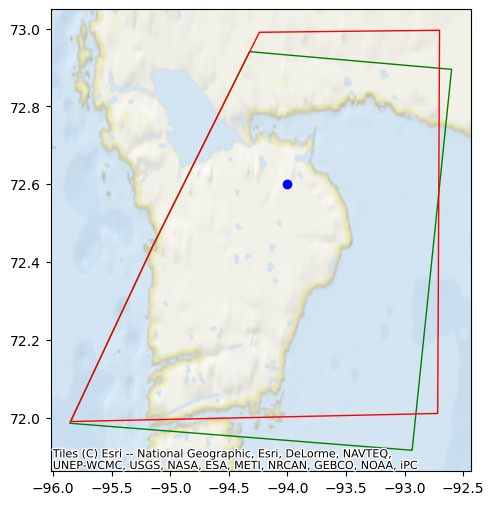

In [17]:
fig,ax=plt.subplots(figsize=(12,6))
colors = ['green','red']
i=0
for granule_id in np.unique(df_geo['granule_id']):
    df_geo_loc = df_geo.loc[df_geo['granule_id']==granule_id]
    df_geo_loc[["geometry"]].plot(facecolor="none",edgecolor=colors[i],ax=ax)
    i=i+1
ax.plot(lon,lat,'o',c='blue')
contextily.add_basemap(
    ax, crs = df_geo.crs, source=contextily.providers.Esri.NatGeoWorldMap, alpha=0.5
)

As we can see, over a point, there are two unique granules overlapping each other. This is a particular issue over polar region. 

Given the situation that we are only interested in one granule (for example, the red tile), using the current search feature from CMR-STAC could not account for this functionality. 

Next sections, I will explain more in detail why the CMR-STAC does not support this feature and how can we resolve the problem. 

## 2.2. What are the challenges? 

We can not query using STAC-API using keywords contains in field “id”
**STAC API** backend ***do not*** supports substring search on ```id```. 

https://cmr.earthdata.nasa.gov/cloudstac/LPCLOUD—is part of NASA's Common Metadata Repository (CMR) STAC implementation. As of now, this API does not support the STAC API Filter Extension, specifically the Common Query Language 2 (CQL2), which includes advanced filtering capabilities like substring matching on the id field.


## 2.3. What is the solution?

Until CMR-STAC updates the language to support the query by subsetting of id, anything we modify from client-side would ***not*** cause the difference. 

Therefore, unfortunately, the only possible to solution is we add an additional feature to filter out the ```items``` with relevant keywords after executing ```search.get_items()```. Of course, by doing this, we still call all responses without filtering the keyword id and thus the responding speed is still slow. 

Get an example, we want to only search for granule ```T14XPF```, assigned it as a ```granule_id``` in the ```search_cmr_stac``` function


In [18]:
np.unique(df_geo['granule_id'])

array(['T14XPF', 'T15XVA'], dtype=object)

In [19]:
granule_id = 'T14XPF'
date_begin='03-11'
date_end='03-11'
item_list_filter = search_cmr_stac(baseline_year,analysis_year,
                                   lat_range,lon_range,date_begin,date_end,
                                   granule_id=granule_id)

2021
Found 1 granules at point [-94.001, 72.59899999999999, -93.999, 72.601] from 2021-03-11 to 2021-03-11


As a results, using the filter function, the output only contains **1** granules instead of 2 granules because we do not account for other granule ID.

Let check the map of the new results to verify

In [20]:
df_geo_filter = pystac_to_json(item_list_filter)
df_geo_filter.crs = "epsg:4326"

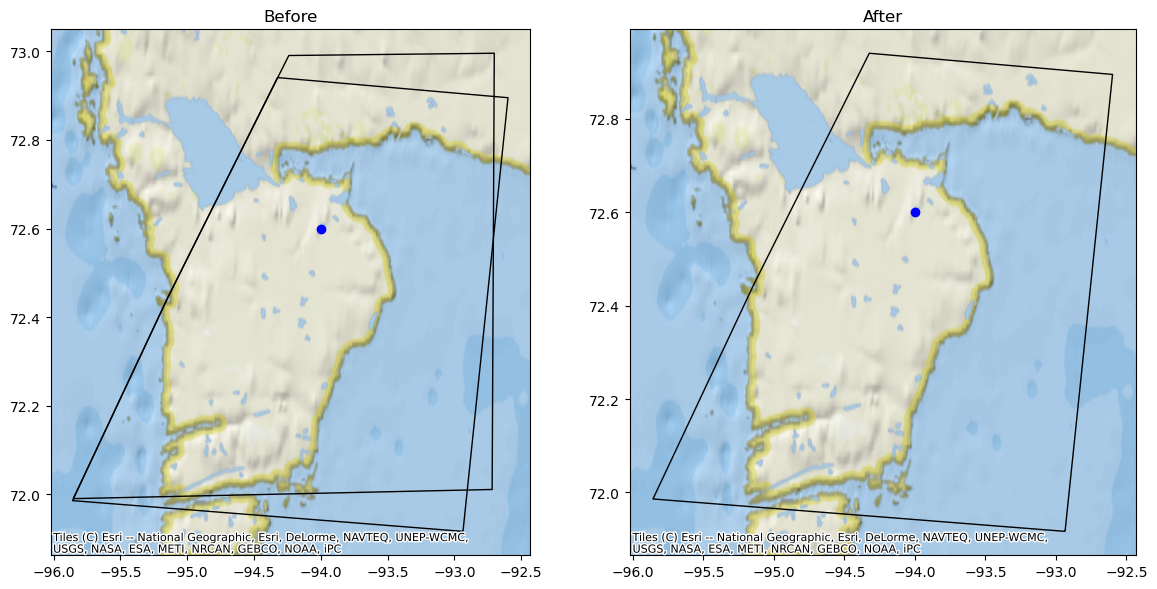

In [23]:
fig, axes = plt.subplots(figsize=(12,6),ncols=2,nrows=1)
df_list = [df_geo,df_geo_filter]
title_list = ['Before','After']
index=0
for ax in axes:
    df_list[index][["geometry"]].plot(facecolor="none",ax=ax)
    contextily.add_basemap(
    ax, crs=df_geo_filter.crs.to_string(), source=contextily.providers.Esri.NatGeoWorldMap)
    ax.plot(lon,lat,'o',c='blue')
    ax.set_title(title_list[index])
    index=index+1
plt.tight_layout()

This notebook contributes to the current workflow to search for HLS tiles using CMR-STAC but add in the filtering by granule ID which have important implications for research development, in particular over polar regions, where many S30 tiles can be overlapping on the same day.

# Additional information
**Contact**: Trang Vo (tv0015@uah.edu) - NASA-IMPACT UAH LAS. 

**Contributor**: xxxxx

**Last modified**: April 2025